In [1]:
using Cairo, PyPlot, IJulia, ColorTypes, Colors, Images;
PyPlot.matplotlib[:interactive](true);
cim(img::Matrix{UInt32}) = CairoImageSurface(img, Cairo.FORMAT_RGB24; flipxy = false) 
cim(img::Matrix{ARGB32}) = cim(reinterpret(UInt32, img))
cim(img::Matrix{RGB24}) = cim(reinterpret(UInt32, img))
cim{T<:Colorant}(img::Matrix{T}) = cim(RGB24.(img))
cim{T<:AbstractFloat}(img::Matrix{T}) = cim(clamp01.(Gray.(img)))
cim(img::Matrix{UInt8}) = cim(Gray.(reinterpret(N0f8, img)))
cim(img::Array{UInt8,3}) = cim(RGB24.(reinterpret(N0f8, img[:,:,1]), reinterpret(N0f8, img[:,:,2]), reinterpret(N0f8, img[:,:,3])));

In [2]:
function fixplot()
    a = gca()
    a[:spines]["top"][:set_visible](false)
    a[:spines]["right"][:set_visible](false)
    a[:yaxis][:set_ticks_position]("left")
    a[:xaxis][:set_ticks_position]("bottom")
    a[:xaxis][:set_tick_params](direction="out")
    a[:yaxis][:set_tick_params](direction="out")
end

fixplot (generic function with 1 method)

In [3]:
function load_trkdata(filename)
    open(filename, "r") do file
        data_length = 16
        n = floor(Int64, filesize(file)/((sizeof(Float64)*data_length)))
        Mmap.mmap(file, Array{Float64,2}, (data_length,n))'
    end
end

load_trkdata (generic function with 1 method)

In [134]:
function load_trkImage(filename)
    open(filename, "r") do file
        w, h = 640, 376
        data_length = w*h;
        n = floor(Int64, filesize(file)/((sizeof(UInt8)*data_length)))
        Mmap.mmap(file, Array{UInt8,3}, (w,h,n))
    end
end

load_trkImage (generic function with 1 method)

In [135]:
function load_trkdata_mr(filename)
    open(filename, "r") do file
        data_length = 2
        n = floor(Int64, filesize(file)/((sizeof(Int64)*data_length)))
        Mmap.mmap(file, Array{Int64,2}, (data_length,n))'
    end
end

load_trkdata_mr (generic function with 1 method)

In [4]:
filename_data = "Fly_Data_Mar_28_Trial2.bin"
 #filename_im = "Fly_Image_Apr_1_Trial_5_1_40.bin"
#filename_mobrob = "MobRob_Data_Apr_1_Trial_5_1_40.bin"

"Fly_Data_Mar_28_Trial2.bin"

In [5]:
trk_data = load_trkdata(filename_data)[1001:7000,:] # may need to cut at the begining. 

6000×16 Array{Float64,2}:
  1605.0  15784.0  15904.0  341.664  …  4119.5  16196.0  8815.0  12342.0
  1606.0  15657.0  16102.0  343.828     4056.5  16197.0  8815.0  12342.0
  1608.0  15672.0  15978.0  348.057     4112.5  16197.0  8815.0  12342.0
  1609.0  15639.0  16042.0  350.007     4153.0  16197.0  8815.0  12342.0
  1611.0  15676.0  15936.0  355.215     4190.5  16197.0  8815.0  12342.0
  1613.0  15664.0  16017.0  364.823  …  4180.5  16197.0  8815.0  12342.0
  1614.0  15745.0  15920.0  369.086     4155.0  16197.0  8815.0  12342.0
  1616.0  15613.0  16117.0  376.917     4090.0  16197.0  8815.0  12342.0
  1617.0  15553.0  16065.0  381.054     4008.5  16197.0  8815.0  12342.0
  1619.0  15490.0  16093.0  393.74      4074.5  16197.0  8815.0  12342.0
  1621.0  15681.0  15837.0  404.485  …  4248.5  16197.0  8815.0  12342.0
  1622.0  15602.0  16024.0  408.694     4307.5  16197.0  8815.0  12342.0
  1624.0  15751.0  15841.0  420.214     4329.5  16197.0  8814.0  12342.0
     ⋮                   

In [6]:
t = (trk_data[:,1] - trk_data[1,1])/100;

In [7]:
encoder = trk_data[:,14:16]/4096*2*pi;
encoder_diff = vcat([0 0 0], diff(encoder,1));# rad

In [8]:
encoder_diff

6000×3 Array{Float64,2}:
 0.0          0.0         0.0
 0.00153398   0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0         -0.00153398  0.0
 ⋮                           
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0         -0.00153398  0.0
 0.0          0.0         0.0
 0.0          0.0         0.0
 0.0          0.00153398  0.0
 0.0          0.0         0.0
 0.0         -0.00153398  0.0
 0.0          0.00153398  0.0
 0.0          0.0         0.0
 0.0          0.0         0.0

In [9]:
R = 25.4*2#*1e-3
D = 2*R
D_wheel = 100;#2.75*25.4#*1e-3

angle_wheel = deg2rad(40);

α1 = deg2rad(0);
α2 = deg2rad(120);
α3 = deg2rad(240);

sth = sin(angle_wheel)
cth = cos(angle_wheel);

R_x1 = R*cos(angle_wheel)
R_z1 = R*sin(angle_wheel)
sth = sin(angle_wheel)
cth = cos(angle_wheel);
sβ1 = sin(0); cβ1 = cos(0);
sβ2 = sin(deg2rad(120)); cβ2 = cos(deg2rad(120));
sβ3 = sin(deg2rad(240)); cβ3 = cos(deg2rad(240));

J = reshape(R_z1/R^2*[R_z1*cβ1 R_z1*cβ2 R_z1*cβ3 -R_z1*sβ1 -R_z1*sβ2 -R_z1*sβ3 -R_x1 -R_x1 -R_x1],3,3)'

RM = reshape([0 R 0 R 0 0 0 0 1],3,3)'

RJ2 = RM*J # X_dot = RJ2 * Ω_wheel

3×3 Array{Float64,2}:
  0.0       -18.1773     18.1773  
 20.9893    -10.4947    -10.4947  
 -0.492404   -0.492404   -0.492404

In [10]:
dp = (RJ2*encoder_diff')' # mm, mm, rad

6000×3 Array{Float64,2}:
  0.0         0.0         0.0        
  0.0         0.0321972  -0.000755338
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0278836   0.0160986   0.000755338
  ⋮                                  
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0         0.0         0.0        
  0.0278836   0.0160986   0.000755338
  0.0         0.0         0.0        
  0.0         0.0         0.0        
 -0.0278836  -0.0160986  -0.000755338
  0.0         0.0         0.0        
  0.0278836   0.0160986   0.000755338
 -0.0278836  -0.0160986  -0.000755338
  0.0         0.0         0.0        
  0.0         0.0        

In [11]:
th = cumsum(dp[:,3]) + deg2rad(20)# rad;
cth_ref = cos.(-th)
sth_ref = sin.(-th)
dp_rot = hcat(cth_ref.*dp[:,1] - sth_ref.*dp[:,2], sth_ref.*dp[:,1] + cth_ref.*dp[:,2]);

In [12]:
v_sp = sqrt.(sum(dp[:,1:2].^2,2)); # velocity of the sphere (v_sphere in x-y plane)

In [13]:
p_sp = hcat(cumsum(dp_rot,1), th);

In [14]:
sum(v_sp)

304.34631355758006

# Fly motion

In [15]:
px_dist = 1/38.40983291722681 # mm/px

0.026035000000000003

In [16]:
trk_data[1,10:12]

3-element Array{Float64,1}:
  0.921684
 -0.858538
  0.258514

In [17]:
img_err = hcat(trk_data[:,7:8], trk_data[:,9]) ## mm,mm, rad
img_err[:,1:2] *= px_dist;
img_err_dist = sqrt.(sum(img_err[:,1:2].^2,2));

In [18]:
average_img_err_dist = sum(img_err_dist)/6000

1.8210850459434962

In [19]:
abs_theta_err = abs.(img_err[:,3])

6000-element Array{Float64,1}:
 0.00208624
 0.0189408 
 0.0475854 
 0.0640816 
 0.0702065 
 0.0165149 
 0.00156319
 0.00489347
 0.0368343 
 0.11361   
 0.111394  
 0.118323  
 0.100474  
 ⋮         
 0.013407  
 0.0395584 
 0.0606014 
 0.10015   
 0.0983637 
 0.0721127 
 0.0625275 
 0.0570396 
 0.0524725 
 0.0632162 
 0.0686505 
 0.0843478 

In [20]:
average_theta_err_dist_ = rad2deg(sum(abs_theta_err)/6000)

7.039149833208414

In [21]:
abs(-1)

1

In [22]:
t[2244]

37.99

In [23]:
length(t)/100

60.0

In [24]:
v_sp[2245]*100

3.219723861514974

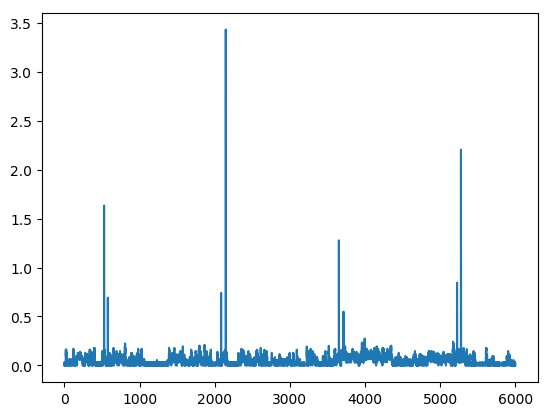

(3.4300260957773303, 2148)

In [25]:
plot(v_sp)
findmax(v_sp)

In [26]:
hcat(v_sp[2145:2155],t[2145:2155])

11×2 Array{Float64,2}:
 0.0        35.48
 0.0        35.5 
 0.0        35.51
 3.43003    36.36
 0.674607   36.46
 0.116089   36.49
 0.0557673  36.5 
 0.0851859  36.52
 0.0557673  36.54
 0.0643945  36.55
 0.0965917  36.57

In [27]:
ds = v_sp;
dt = vcat(0.01, diff(t))
vel_sp = ds./dt

6000×1 Array{Float64,2}:
 0.0    
 3.21972
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 1.60986
 ⋮      
 0.0    
 0.0    
 0.0    
 1.60986
 0.0    
 0.0    
 1.60986
 0.0    
 1.60986
 1.60986
 0.0    
 0.0    

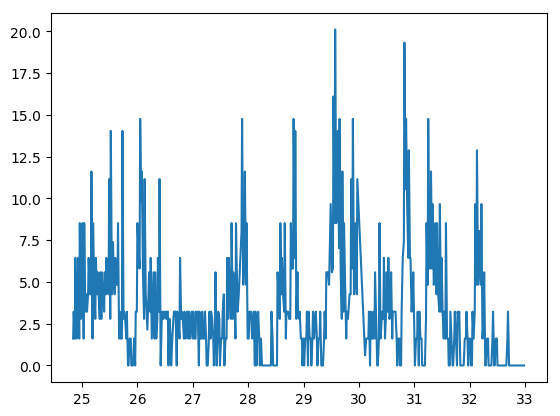

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13fc8c890>

In [28]:
id = (500:1000)+500*2
plot(t[id],vel_sp[id])

In [29]:
using Images

In [30]:
v2 = imfilter(vel_sp, Kernel.gaussian((10,1), (31,1)));

In [31]:
v_sp

6000×1 Array{Float64,2}:
 0.0      
 0.0321972
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0321972
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0321972
 0.0      
 0.0      
 0.0321972
 0.0      
 0.0321972
 0.0321972
 0.0      
 0.0      

In [32]:
reshape(omega_sp, 6000,1)

LoadError: [91mUndefVarError: omega_sp not defined[39m

In [33]:
th2 = imfilter(reshape(omega_sp, 6000,1), Kernel.gaussian((10,1), (31,1)))

LoadError: [91mUndefVarError: omega_sp not defined[39m

In [34]:
plot(th2)

LoadError: [91mUndefVarError: th2 not defined[39m

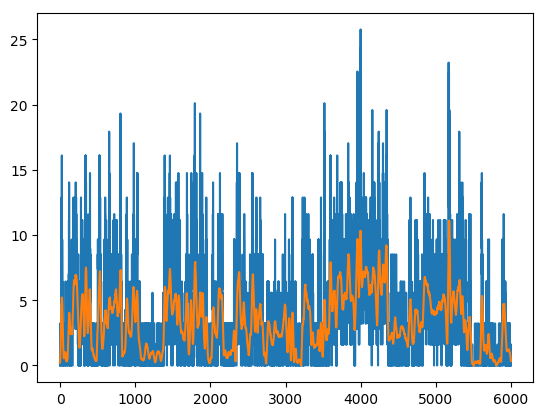

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141a6be90>

In [35]:
plot(vel_sp)
plot(v2)


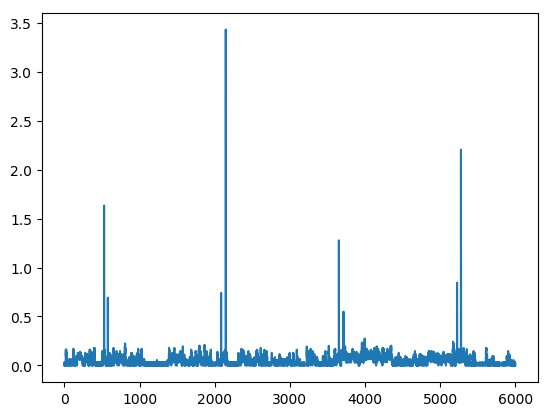

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14222a450>

In [36]:
plot(v_sp)

In [37]:
v_sp

6000×1 Array{Float64,2}:
 0.0      
 0.0321972
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0321972
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0321972
 0.0      
 0.0      
 0.0321972
 0.0      
 0.0321972
 0.0321972
 0.0      
 0.0      

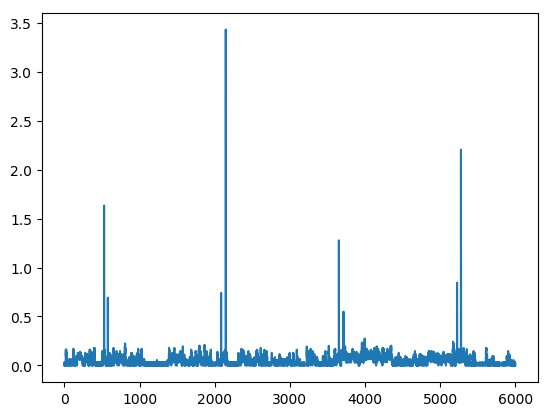

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1423e23d0>

In [38]:
plot(v_sp)

In [54]:
v_sp

6000×1 Array{Float64,2}:
 0.0      
 0.0321972
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0      
 0.0321972
 ⋮        
 0.0      
 0.0      
 0.0      
 0.0321972
 0.0      
 0.0      
 0.0321972
 0.0      
 0.0321972
 0.0321972
 0.0      
 0.0      

In [56]:
vel_sp

6000×1 Array{Float64,2}:
 0.0    
 3.21972
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 1.60986
 ⋮      
 0.0    
 0.0    
 0.0    
 1.60986
 0.0    
 0.0    
 1.60986
 0.0    
 1.60986
 1.60986
 0.0    
 0.0    

In [62]:
maximum(vel_sp)

25.75779089212457

In [66]:
sum(abs.(vel_sp))/6000

3.401007340830825

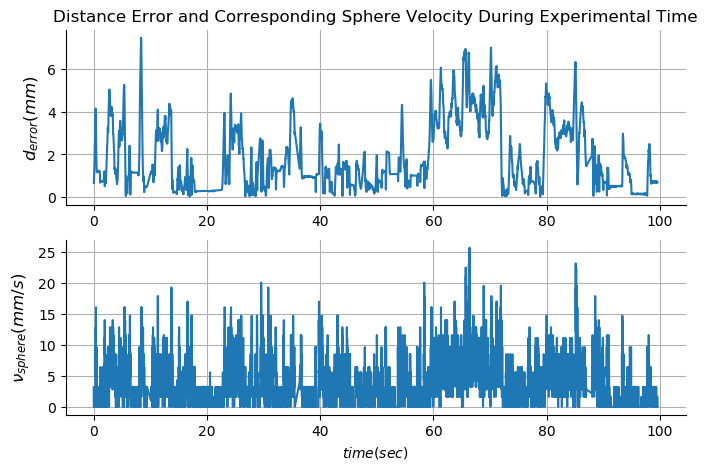

/Users/Suddarsun/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [39]:
id = 1:length(t)
figure(figsize=(8,5))
subplot(2,1,1)
title("Distance Error and Corresponding Sphere Velocity During Experimental Time")
plot(t[id], img_err_dist[id,1]);#, linewidth = 0.5); 

# legend(["Fly","sphere"])
ylabel(L"d_{error} (mm)", fontsize="large")
#xlabel(L"time(sec)")
grid(:on)
fixplot()

subplot(2,1,2)
plot(t[id], vel_sp[id]);#, linewidth = 0.2);
# legend(["Fly","sphere"])
ylabel(L"\nu_{sphere} (mm/s)", fontsize="large")
xlabel(L"time(sec)")
grid(:on)
fixplot()

savefig("d_error_v_sph.png")



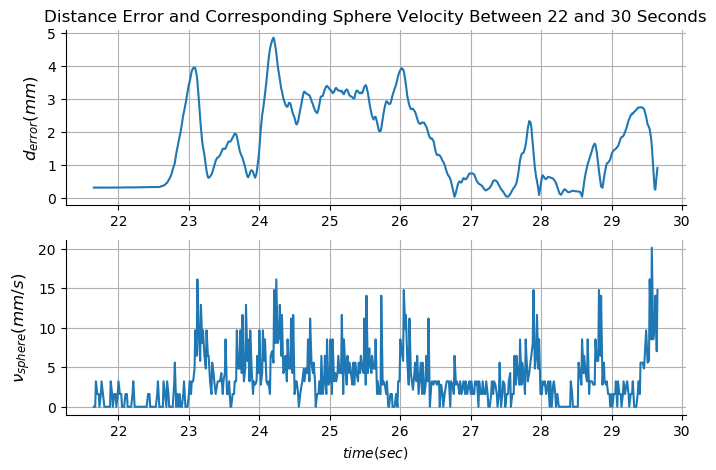

In [40]:
id = (1:500) + 650 + 500 + 150
figure(figsize=(8,5))
subplot(2,1,1)
title("Distance Error and Corresponding Sphere Velocity Between 22 and 30 Seconds")
plot(t[id], img_err_dist[id,1]); 
# legend(["Fly","sphere"])
ylabel(L"d_{error} (mm)",fontsize="large")
#xlabel("time(sec)")
grid(:on)
fixplot()

subplot(2,1,2)
plot(t[id], vel_sp[id]);
# legend(["Fly","sphere"])
ylabel(L"\nu_{sphere} (mm/s)",fontsize="large")
xlabel(L"time(sec)")
grid(:on)
fixplot()

savefig("d_error_v_sph_zoom.png")


In [41]:
dt = vcat(0.01, diff(t))
omega_sp = dp[:,3]./dt

6000-element Array{Float64,1}:
  0.0      
 -0.0755338
  0.0      
  0.0      
  0.0      
  0.0      
  0.0      
  0.0      
  0.0      
  0.0      
  0.0      
  0.0      
  0.0377669
  ⋮        
  0.0      
  0.0      
  0.0      
  0.0377669
  0.0      
  0.0      
 -0.0377669
  0.0      
  0.0377669
 -0.0377669
  0.0      
  0.0      

In [42]:
th2 = imfilter(omega_sp, Kernel.gaussian((10,1),(3,1)));

LoadError: [91mArgumentError: ImageFiltering.Pad{2}(:replicate, (1, 0), (1, 0)) lacks the proper padding sizes for an array with 1 dimensions[39m

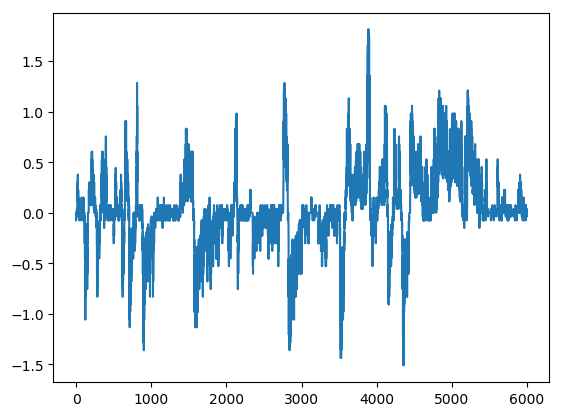

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x142cab350>

In [43]:
plot(omega_sp)

In [74]:
rad2deg(sum(abs.(omega_sp))/6000)

11.90436318099703

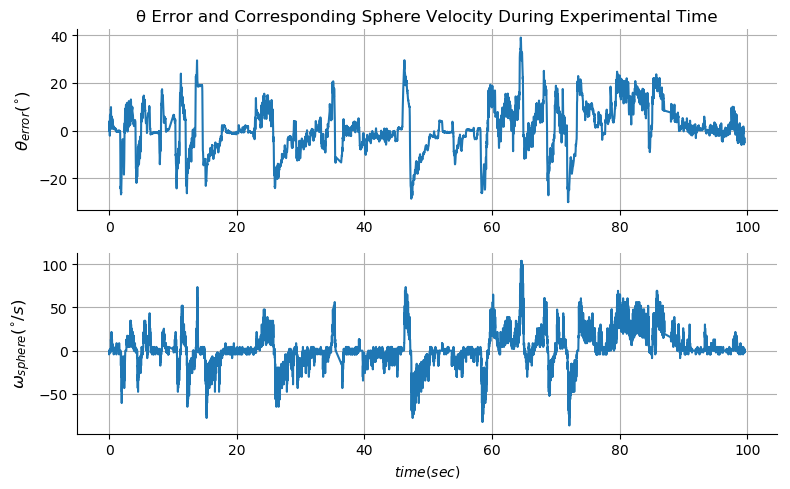

In [44]:
id = 1:length(t)
figure(figsize=(8,5))
subplot(2,1,1)
title("θ Error and Corresponding Sphere Velocity During Experimental Time")

plot(t[id], rad2deg.(img_err[id,3])); 
# legend(["Fly","sphere"])
ylabel(L"θ_{error} (^{\circ})",fontsize="large")
#xlabel("time(sec)")
grid(:on)

fixplot()

subplot(2,1,2)
plot(t[id], rad2deg.(omega_sp));
# legend(["Fly","sphere"])
ylabel(L"\omega_{sphere} (^{\circ}/s)",fontsize="large")
xlabel(L"time(sec)")
grid(:on)
fixplot()

tight_layout()

savefig("th_error_v_sph.png")


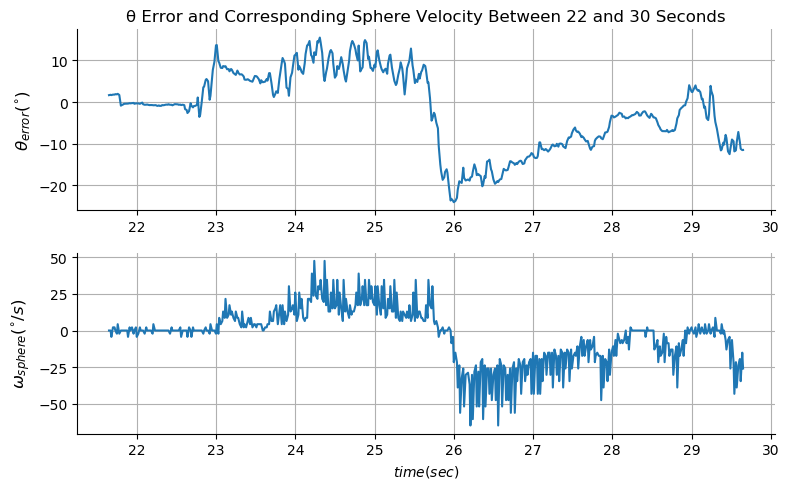

In [45]:
id = (1:500) + 650 + 500 + 150
figure(figsize=(8,5))
subplot(2,1,1)
title("θ Error and Corresponding Sphere Velocity Between 22 and 30 Seconds")
plot(t[id], rad2deg.(img_err[id,3])); 
# legend(["Fly","sphere"])
ylabel(L"θ_{error} (^{\circ})",fontsize="large")
#xlabel("time(sec)")
grid(:on)

fixplot()

subplot(2,1,2)
plot(t[id], rad2deg.(omega_sp[id]));
# legend(["Fly","sphere"])
ylabel(L"\omega_{sphere} (^{\circ}/s)",fontsize="large")
xlabel(L"time(sec)")
grid(:on)
fixplot()

tight_layout()

savefig("th_error_v_sph_zoom.png")


In [46]:
p_sp

6000×3 Array{Float64,2}:
  0.0         0.0        0.349066
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0109892   0.0302638  0.348311
  0.0426973   0.0358548  0.349066
  ⋮                              
 -4.60143    40.8278     3.69446 
 -4.60143    40.8278     3.69446 
 -4.60143    40.8278     3.69446 
 -4.63361    40.8288     3.69521 
 -4.63361    40.8288     3.69521 
 -4.63361    40.8288     3.69521 
 -4.60143    40.8278     3.69446 
 -4.60143    40.8278     3.69446 
 -4.63361    40.8288     3.69521 
 -4.60142    40.8278     3.69446 
 -4.60142    40.8278     3.69446 
 -4.60142    40.8278     3.69446 

In [47]:
v_sphere_encoder = encoder_diff./dt

6000×3 Array{Float64,2}:
 0.0        0.0       0.0
 0.153398   0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0       -0.076699  0.0
 ⋮                       
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0       -0.076699  0.0
 0.0        0.0       0.0
 0.0        0.0       0.0
 0.0        0.076699  0.0
 0.0        0.0       0.0
 0.0       -0.076699  0.0
 0.0        0.076699  0.0
 0.0        0.0       0.0
 0.0        0.0       0.0

In [50]:
mean(v_sphere_encoder)

-0.024388520681027502

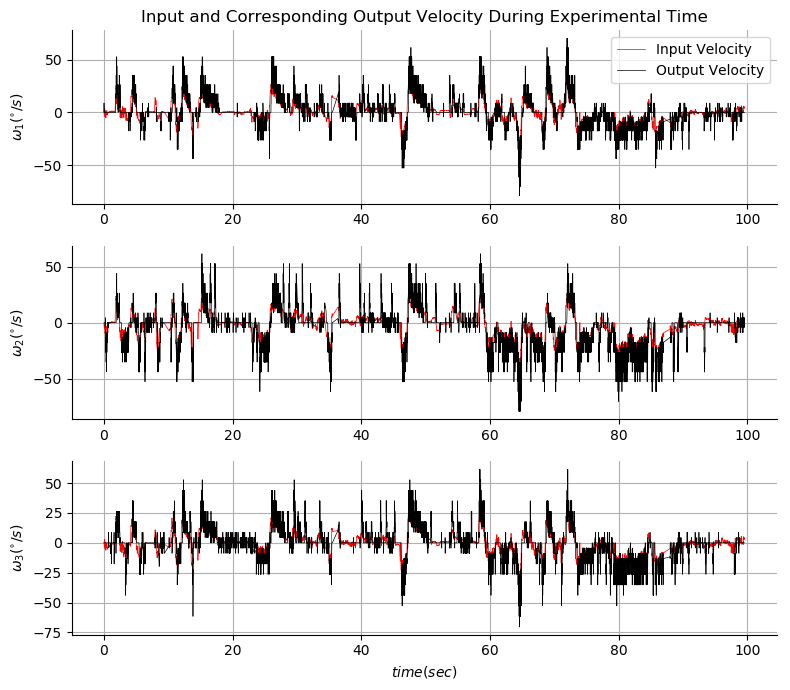

In [48]:
id = 1:length(t)
figure(figsize=(8,7))
subplot(3,1,1)
title("Input and Corresponding Output Velocity During Experimental Time")

plot(t[id], trk_data[id,10], linewidth = 0.5, color = "red", label = "Input Velocity"); 
fixplot()

grid(:on)
plot(t[id], rad2deg.(v_sphere_encoder[id,1]), linewidth = 0.5, color = "black", label = "Output Velocity");
ylabel(L"\omega_{1} (^{\circ}/s)")
grid(:on)
fixplot()
legend()


subplot(3,1,2)
plot(t[id], trk_data[id,11], linewidth = 0.5, color = "red", label = "Input Velocity"); 
fixplot()

grid(:on)
plot(t[id], rad2deg.(v_sphere_encoder[id,2]), linewidth = 0.5, color = "black", label = "Output Velocity");
ylabel(L"\omega_{2} (^{\circ}/s)")

grid(:on)
fixplot()

subplot(3,1,3)


plot(t[id], trk_data[id,12], linewidth = 0.5, color = "red", label = "Input Velocity"); 
fixplot()

grid(:on)
plot(t[id], rad2deg.(v_sphere_encoder[id,3]), linewidth = 0.5, color = "black", label = "Output Velocity");
ylabel(L"\omega_{3} (^{\circ}/s)")
xlabel(L"time(sec)")

grid(:on)
fixplot()

tight_layout()


savefig("inp_oup_vel_wh.eps")


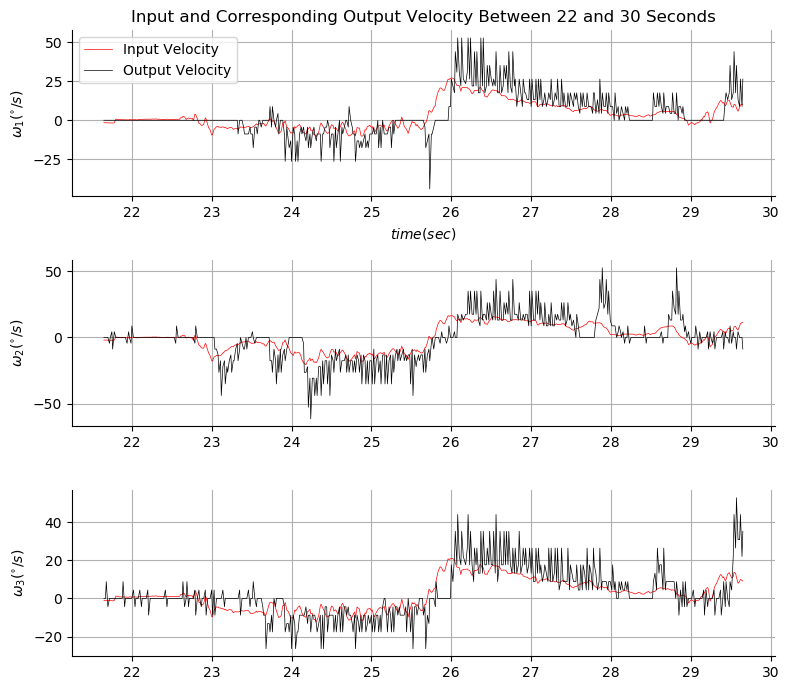

In [49]:
id = id = (1:500) + 650 + 500 + 150
figure(figsize=(8,7))
subplot(3,1,1)
title("Input and Corresponding Output Velocity Between 22 and 30 Seconds")

plot(t[id], trk_data[id,10], linewidth = 0.5, color = "red", label = "Input Velocity"); 
fixplot()

grid(:on)
plot(t[id], rad2deg.(v_sphere_encoder[id,1]), linewidth = 0.5, color = "black", label = "Output Velocity");
ylabel(L"\omega_{1} (^{\circ}/s)")
xlabel(L"time(sec)")
grid(:on)
fixplot()
legend()


subplot(3,1,2)
plot(t[id], trk_data[id,11], linewidth = 0.5, color = "red", label = "Input Velocity"); 
fixplot()

grid(:on)
plot(t[id], rad2deg.(v_sphere_encoder[id,2]), linewidth = 0.5, color = "black", label = "Output Velocity");
ylabel(L"\omega_{2} (^{\circ}/s)")

grid(:on)
fixplot()

subplot(3,1,3)


plot(t[id], trk_data[id,12], linewidth = 0.5, color = "red", label = "Input Velocity"); 
fixplot()

grid(:on)
plot(t[id], rad2deg.(v_sphere_encoder[id,3]), linewidth = 0.5, color = "black", label = "Output Velocity");
ylabel(L"\omega_{3} (^{\circ}/s)")

grid(:on)
fixplot()

tight_layout()

savefig("inp_oup_vel_wh_zoom.eps")
